<a href="https://colab.research.google.com/github/se16wangmeiwei/zoom-slow-mo/blob/main/zoom_slow_mo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Prepare

env:pytroch1.8.1+cu101
DCNv2:use this url :https://github.com/tteepe/DCNv2.git

tteepe'fork is actually a JIT-compiled version so we don't have to do compile it.

In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


安装依赖包DCNv2

In [ ]:
cd DCNv2

/content/drive/MyDrive/DCNv2


In [ ]:
!sudo apt-get install ninja-build

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  ninja-build
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 93.3 kB of archives.
After this operation, 296 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 ninja-build amd64 1.8.2-1 [93.3 kB]
Fetched 93.3 kB in 1s (86.4 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package ninja-build.
(Reading database ... 160980 files and directo

In [ ]:
ls

DCN/  LICENSE  README.md  requirements-cpu.txt  requirements-gpu.txt  tests/


In [ ]:
cd /content/drive/MyDrive/Zooming-Slow-Mo-CVPR-2020

/content/drive/MyDrive/Zooming-Slow-Mo-CVPR-2020


In [ ]:
!pip install -r requirements.txt

clear_output()

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/DCNv2/DCN')

加载预训练模型的网络结构和参数

In [ ]:
cd /content/drive/MyDrive/Zooming-Slow-Mo-CVPR-2020/codes/

/content/drive/MyDrive/Zooming-Slow-Mo-CVPR-2020/codes


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Zooming-Slow-Mo-CVPR-2020/codes/utils')

In [ ]:
import models.modules.Sakuya_arch as Sakuya_arch

In [ ]:
import glob
import os.path as osp
import torch
import numpy as np
import util
import torchvision.transforms as transforms

In [ ]:
def single_forward(model, imgs_in):
    with torch.no_grad():
        # imgs_in.size(): [1,n,3,h,w]
        b,n,c,h,w = imgs_in.size()
        h_n = int(4*np.ceil(h/4))
        w_n = int(4*np.ceil(w/4))
        imgs_temp = imgs_in.new_zeros(b,n,c,h_n,w_n)
        imgs_temp[:,:,:,0:h,0:w] = imgs_in

        model_output = model(imgs_temp)
        # model_output.size(): torch.Size([1, 3, 4h, 4w])
        model_output = model_output[:, :, :, 0:scale*h, 0:scale*w]
        if isinstance(model_output, list) or isinstance(model_output, tuple):
            output = model_output[0]
        else:
            output = model_output
    return output

In [ ]:
device = torch.device('cuda')
model = Sakuya_arch.LunaTokis(64, 7, 8, 5, 40)
model.load_state_dict(torch.load('/content/drive/MyDrive/Zooming-Slow-Mo-CVPR-2020/experiments/pretrained_models/xiang2020zooming.pth'))
model.to(device)

clear_output()

预处理数据

In [ ]:
sub_folder = sorted(glob.glob('/content/drive/MyDrive/data/Vid4/foliage'))

In [ ]:
sub_folder

['/content/drive/MyDrive/data/Vid4/foliage']

In [ ]:
sub_folder_l = sorted(glob.glob(sub_folder[0]+'/*'))

In [ ]:
select_idx_list = util.test_index_generation(True, 7, len(sub_folder_l))

In [ ]:
select_idx_list

[[[0, 2, 4, 6], [0, 1, 2, 3, 4, 5, 6]]]

# 对120*180的图片进行预测

In [ ]:
imgs = util.read_seq_imgs(sub_folder[0])
device = torch.device('cuda')
for select_idxs in select_idx_list:
  select_idx = select_idxs[0]
  print(select_idx)
  gt_idx = select_idxs[1]
  imgs_in = imgs.index_select(0, torch.LongTensor(select_idx)).unsqueeze(0).to(device)

[0, 2, 4, 6]


In [ ]:
imgs_in.shape

torch.Size([1, 4, 3, 120, 180])

In [ ]:
scale=4
prediction = single_forward(model,imgs_in)

In [ ]:
prediction.shape

torch.Size([1, 7, 3, 480, 720])

In [ ]:
prediction.data.cuda()
clear_output()

In [ ]:
unloader = transforms.ToPILImage()
image1 = prediction[0][0].squeeze(0)
image1 = unloader(image1)

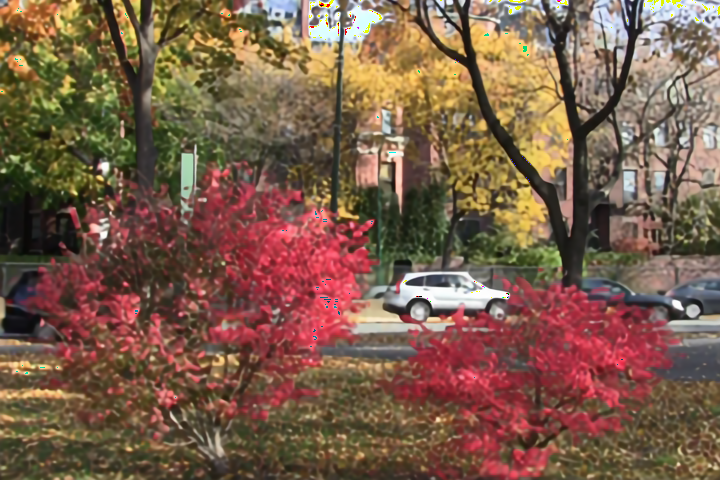

In [ ]:
image1

# 将30*45的作为输入

In [ ]:
type(sub_folder_l)

list

In [ ]:
from PIL import Image

In [ ]:
path = '/content/drive/MyDrive/data/Vid4/LR'

In [ ]:
for i, name in enumerate(sub_folder_l):
  image = Image.open(name)
  image = image.resize((int(image.size[0]/4),int(image.size[1]/4)),Image.BICUBIC)
  image.save(osp.join(path,'{:03d}.png'.format(i+1)))

In [ ]:
imgs2 = util.read_seq_imgs(path)
for select_idxs in select_idx_list:
  select_idx = select_idxs[0]
  gt_idx = select_idxs
  imgs_in2=imgs2.index_select(0,torch.LongTensor(select_idx)).unsqueeze(0).to(device)

In [ ]:
imgs_in2.shape

torch.Size([1, 4, 3, 30, 45])

In [ ]:
scale = 4
prediction2 = single_forward(model, imgs_in2)

In [ ]:
prediction2.squeeze(0)


In [ ]:
prediction2.shape

torch.Size([1, 7, 3, 120, 180])

In [ ]:
prediction2.data.cpu()
unloader = transforms.ToPILImage()
image1 = prediction2[0][0].squeeze(0)
image1 = unloader(image1)

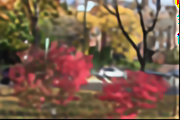

In [ ]:
image1

将视频帧集合成图像

In [ ]:
from make_video import convert_frames_to_video
path_in = '/content/drive/MyDrive/data/inframe/'
path_out = '/content/drive/MyDrive/data/results/demo.mp4'
fps=23.98

In [ ]:
for i,temp in enumerate(prediction2[0]):
  temp = unloader(temp)
  temp.save(osp.join(path_in,'{:03d}.png'.format(i+1)))

NameError: ignored

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join

def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

    # for sorting the file names properly
    # TODO: can be changed depending on your data
    files.sort(key = lambda x: int(x[2:-4]))

    for i in range(len(files)):
        filename=pathIn + files[i]
        print(filename)
        #reading each file
        img = cv2.imread(filename)
        height, width, layers = img.shape
        sizes = (width,height)
        #inserting the frames into an image array
        frame_array.append(img)

    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'MP4V'), fps, sizes)

    for i in range(len(frame_array)):
        # writing to a image array
        out.write(frame_array[i])
    out.release()

In [ ]:
convert_frames_to_video(path_in, path_out, fps)